<a href="https://www.kaggle.com/code/yaaangzhou/version-8-more-eda-ensemble-model-baseline?scriptVersionId=133953320" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv


<h1 style="font-family:verdana;"> <center> 🎯PS3 E17: Binary Classification of Machine Failures: EDA and Baseline models🚀</center> </h1>

***

### Version 8 Changes:

***1. Better visuals and more plots, comes from: https://www.kaggle.com/code/yantxx/xgboost-binary-classifier-machine-failure. I need to admit that his aesthetic is much better than mine.***

***2. Some hyperparameters.***

***3. A simple RFE-CV to select features, the code is a bit ugly here...Because I finished it in the middle of a class...jeje***

___



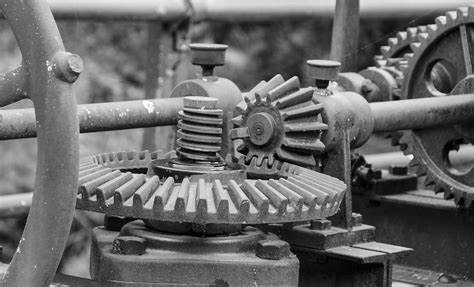

# Imports
___

In [2]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import optuna.integration.lightgbm as lgbo

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV


from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

# Metrics
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import r2_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import warnings
warnings.filterwarnings("ignore")

# Models
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [3]:
# Props to @sergiosaharovskiy

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [4]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
train = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
origin = pd.read_csv("/kaggle/input/machine-failure-predictions/machine failure.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")

#### ***We used those original datas from this url: https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions***

#### ***It's always helpful when we have more datas.***

In [5]:
train['generated'] = 1
origin['generated'] = 0
test['generated'] = 1

In [6]:
train = pd.concat([train, origin], axis = 0).reset_index(drop = True)
train.drop(['id','UDI','Product ID'],axis = 1, inplace = True)
test.drop(['id','Product ID'],axis = 1, inplace = True)
train.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,generated
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,1
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,1
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,1
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,1
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,1


In [7]:
print('The shape of dataset train is :', train.shape)
print('The shape of dataset test is:', test.shape)

The shape of dataset train is : (146429, 13)
The shape of dataset test is: (90954, 12)


# EDA
___

#### ***We're going to present some distribution plots.***

#### ***First of all, let's check the information of the dataset.***

In [8]:
target = 'Machine failure'

num_var = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

bin_var = [
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]

cat_var = ['Type']

In [9]:
train.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
        .background_gradient(subset=['std'], cmap='Blues')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],146429.000000,299.872484,1.872332,295.300000,298.300000,300.000000,301.200000,304.500000
Process temperature [K],146429.000000,309.945475,1.392216,305.700000,308.800000,310.000000,310.900000,313.800000
Rotational speed [rpm],146429.000000,1521.590764,141.950394,1168.000000,1431.000000,1494.000000,1583.000000,2886.000000
Torque [Nm],146429.000000,40.323939,8.610791,3.800000,34.600000,40.400000,46.100000,76.600000
Tool wear [min],146429.000000,104.650800,63.949882,0.000000,49.000000,106.000000,159.000000,253.000000
Machine failure,146429.000000,0.016984,0.129213,0.000000,0.000000,0.000000,0.000000,1.000000
TWF,146429.000000,0.001762,0.041939,0.000000,0.000000,0.000000,0.000000,1.000000
HDF,146429.000000,0.005593,0.074578,0.000000,0.000000,0.000000,0.000000,1.000000
PWF,146429.000000,0.002882,0.053606,0.000000,0.000000,0.000000,0.000000,1.000000
OSF,146429.000000,0.004357,0.065864,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
# summary of train data

def summary(df):
    print(f'data shape is: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

summary(train)

data shape is: (146429, 13)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Type,object,0,0.0,3,NaN,NaN,L,M,L
Air temperature [K],float64,0,0.0,96,295.3,304.5,300.6,302.6,299.3
Process temperature [K],float64,0,0.0,82,305.7,313.8,309.6,312.1,308.5
Rotational speed [rpm],int64,0,0.0,957,1168.0,2886.0,1596,1759,1805
Torque [Nm],float64,0,0.0,615,3.8,76.6,36.1,29.1,26.5
Tool wear [min],int64,0,0.0,246,0.0,253.0,140,200,25
Machine failure,int64,0,0.0,2,0.0,1.0,0,0,0
TWF,int64,0,0.0,2,0.0,1.0,0,0,0
HDF,int64,0,0.0,2,0.0,1.0,0,0,0
PWF,int64,0,0.0,2,0.0,1.0,0,0,0


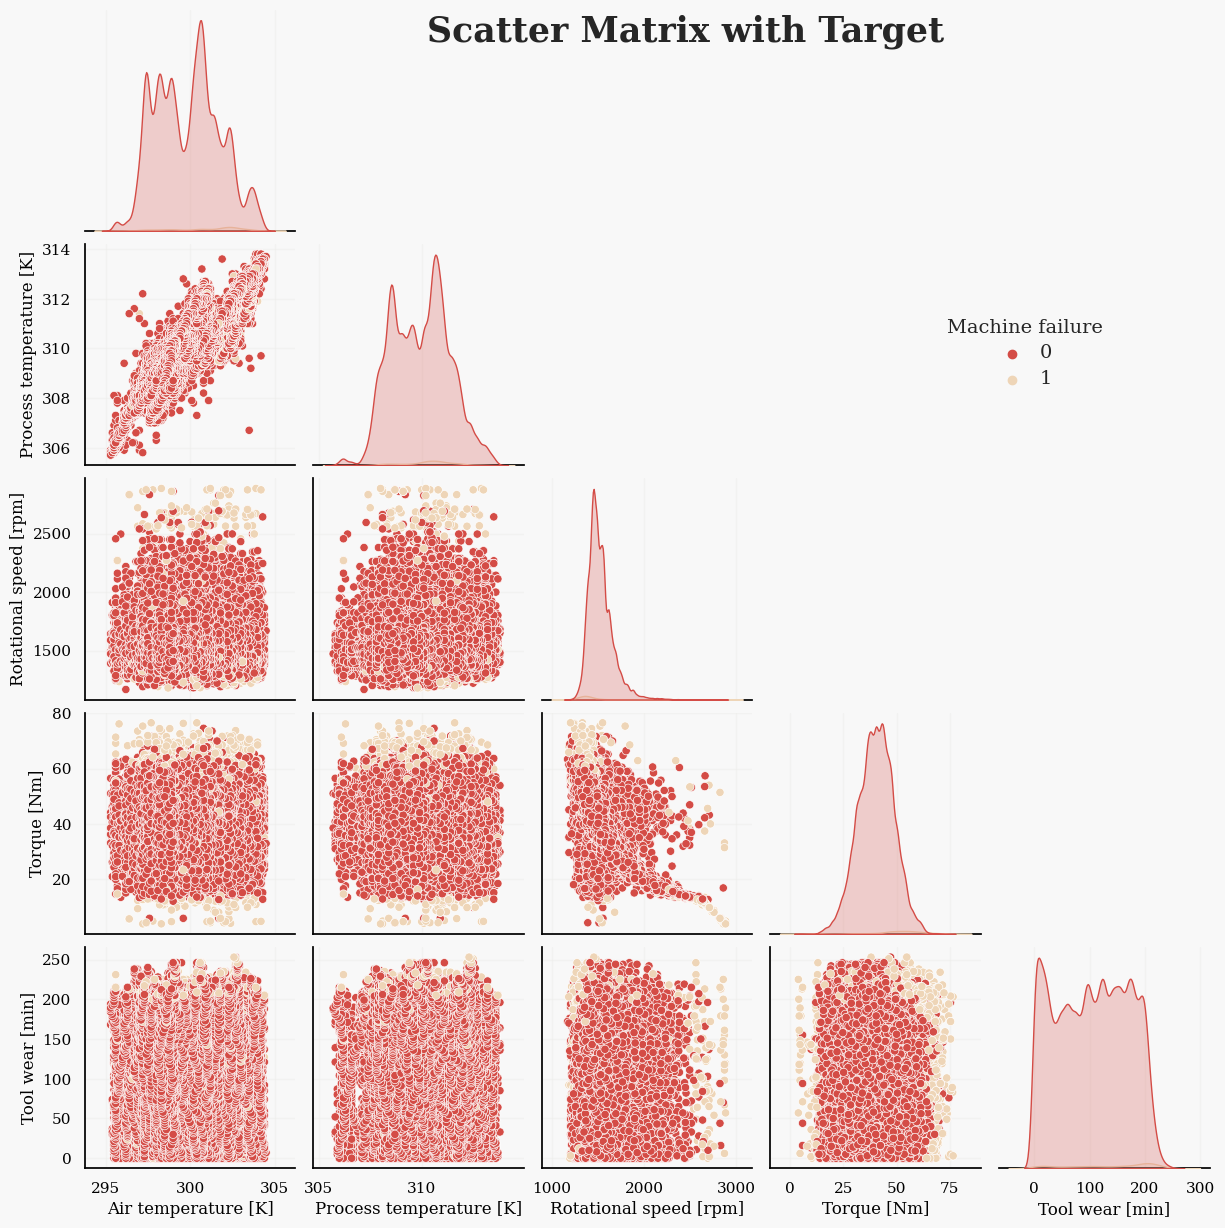

In [11]:
color = ['#d44c46', '#eed5b7']

def plot_pair(df_train,num_var,target,plotname,color = ['#d44c46', '#eed5b7']):
    '''
    Funtion to make a pairplot:
    df_train: total data
    num_var: a list of numeric variable
    target: target variable
    '''
    g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True, palette=color)
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper center'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

plot_pair(train,num_var,target,plotname = 'Scatter Matrix with Target')

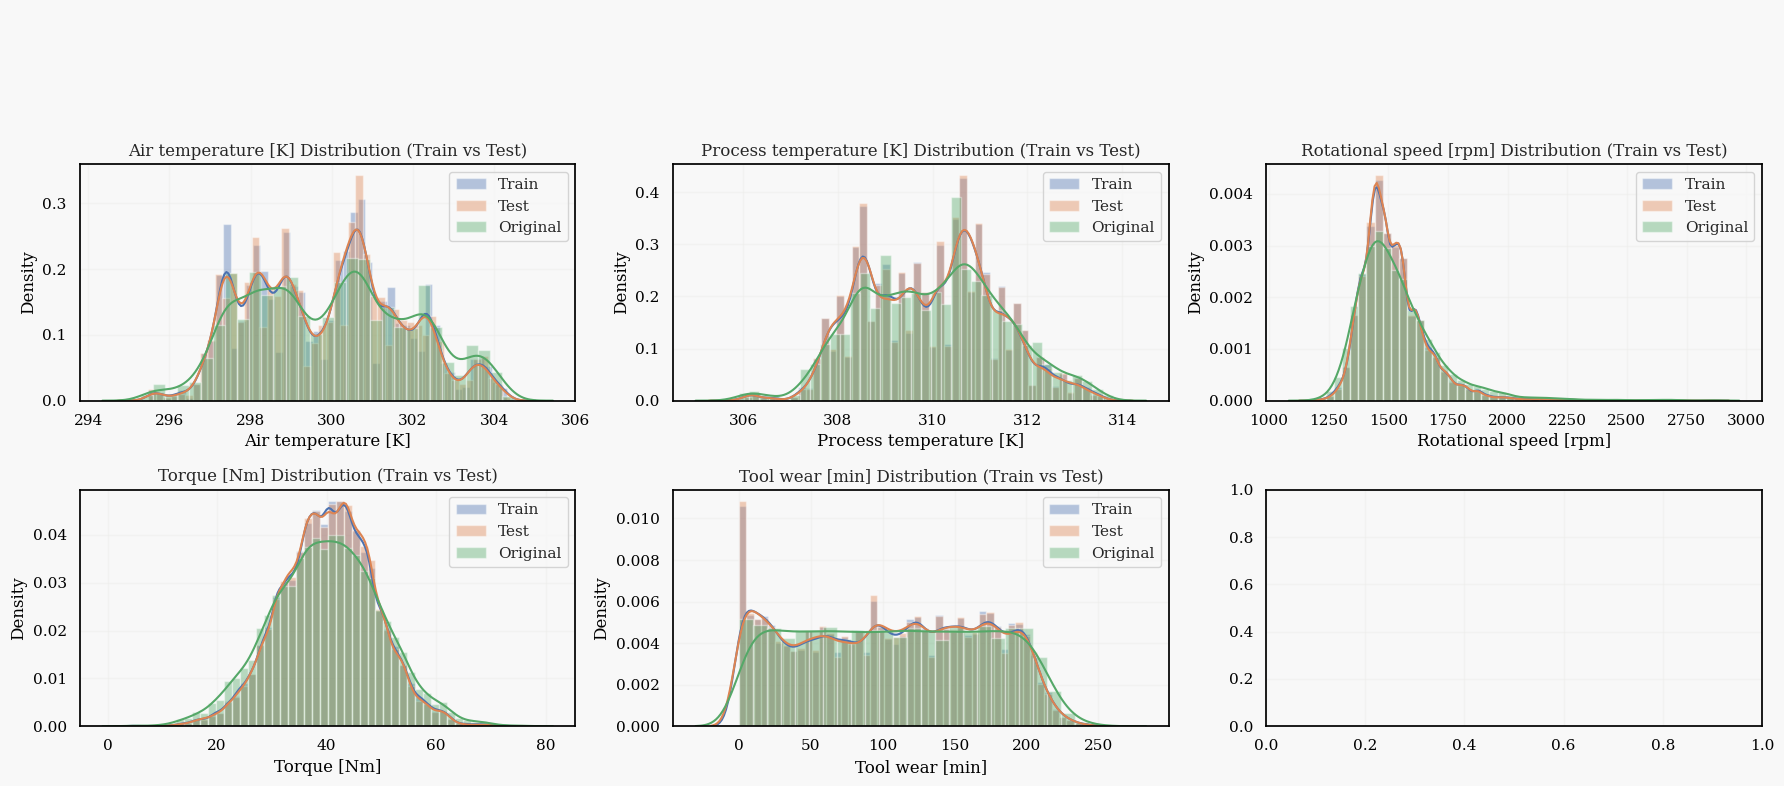

In [12]:
def plot_histograms(df_train, df_test, original, n_cols=3):
    
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        if var_name != 'generated':
            ax = axes[i]
            sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
            if var_name != 'Machine failure':
                sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
            sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
            ax.set_title(f'{var_name} Distribution (Train vs Test)')
            ax.legend()
            
    plt.suptitle(f'\n\n', ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.tight_layout()
    plt.show()
        
plot_histograms(train[num_var], test[num_var], origin[num_var], n_cols=3)

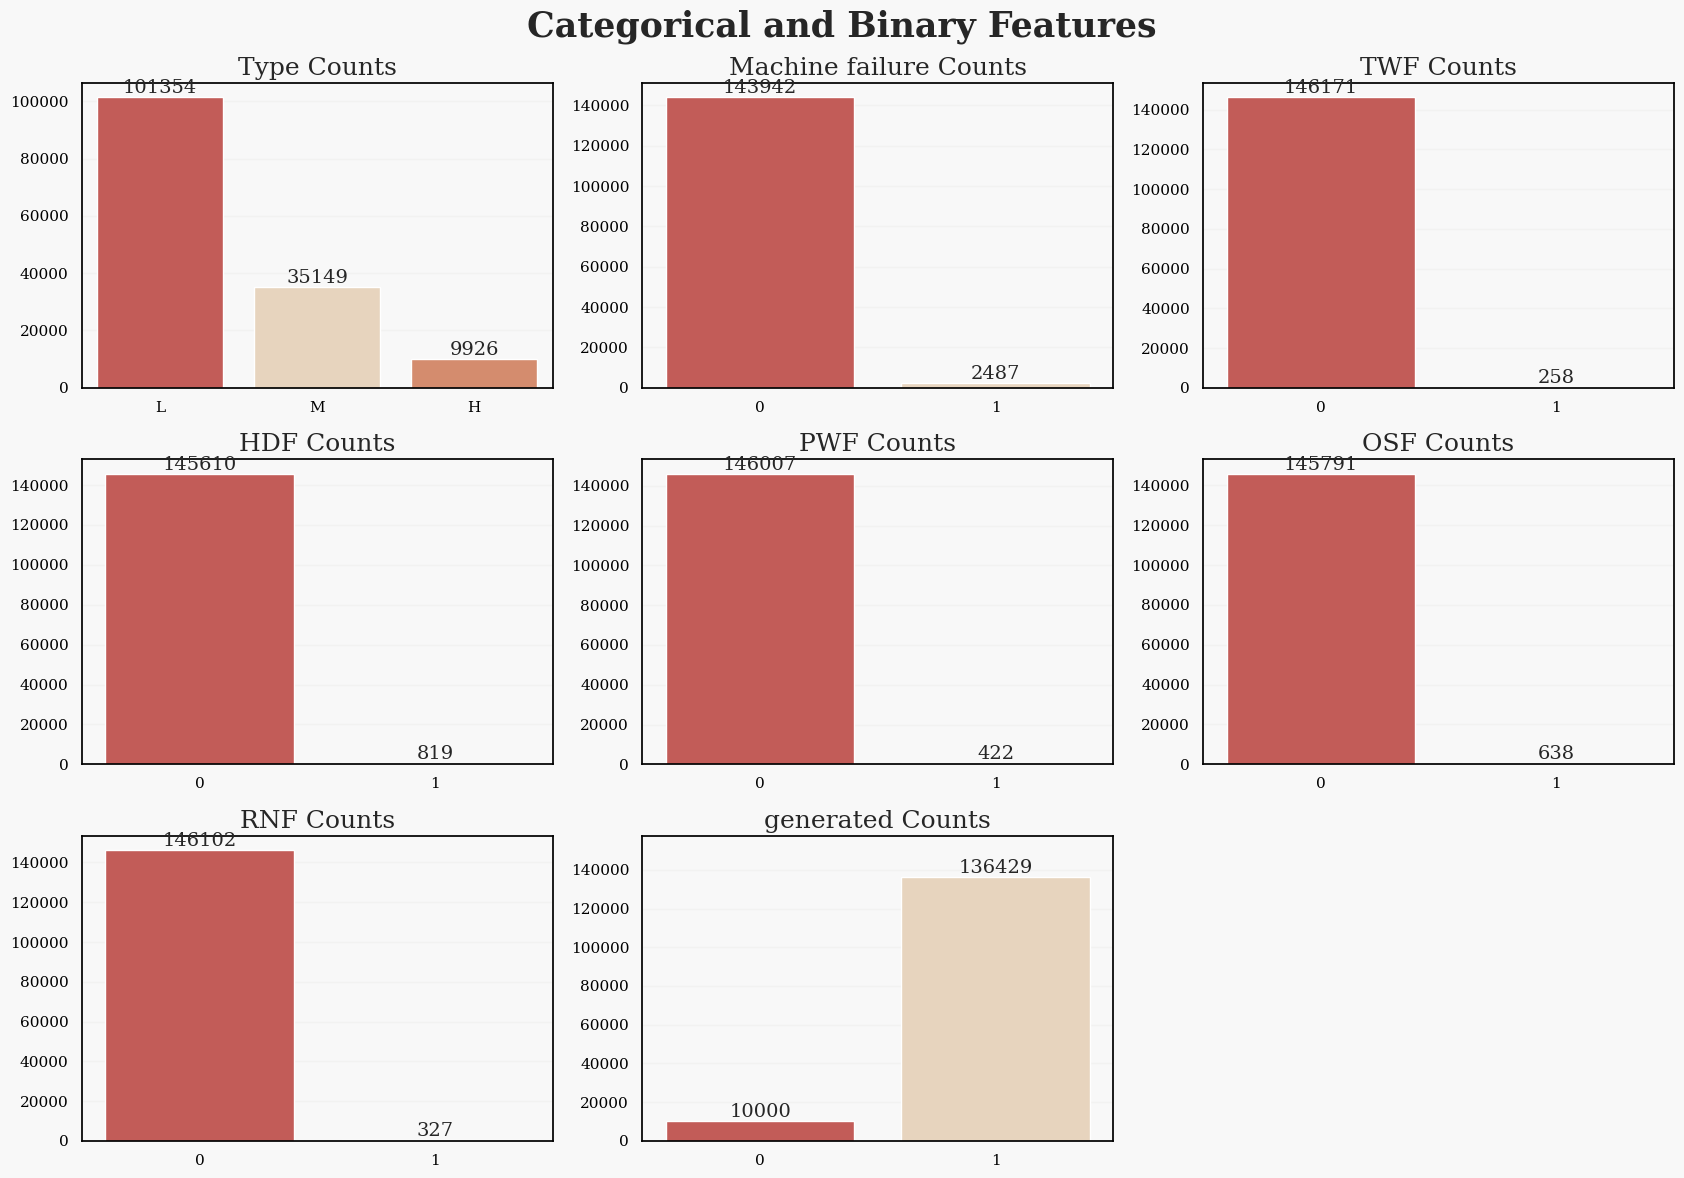

In [13]:
columns = [i for i in train.columns if i not in num_var]

def plot_count(df,columns,n_cols, plotname, color=['#d44c46', '#eed5b7','#e5855d']):
    '''
    # Function to genear countplot
    df: total data
    columns: category variables
    n_cols: num of cols
    '''
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i], palette=color)

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)

        ax[i].tick_params(axis='x', rotation=0)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=14)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)

    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    fig.suptitle(plotname, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_count(train,columns,3,plotname = 'Categorical and Binary Features')

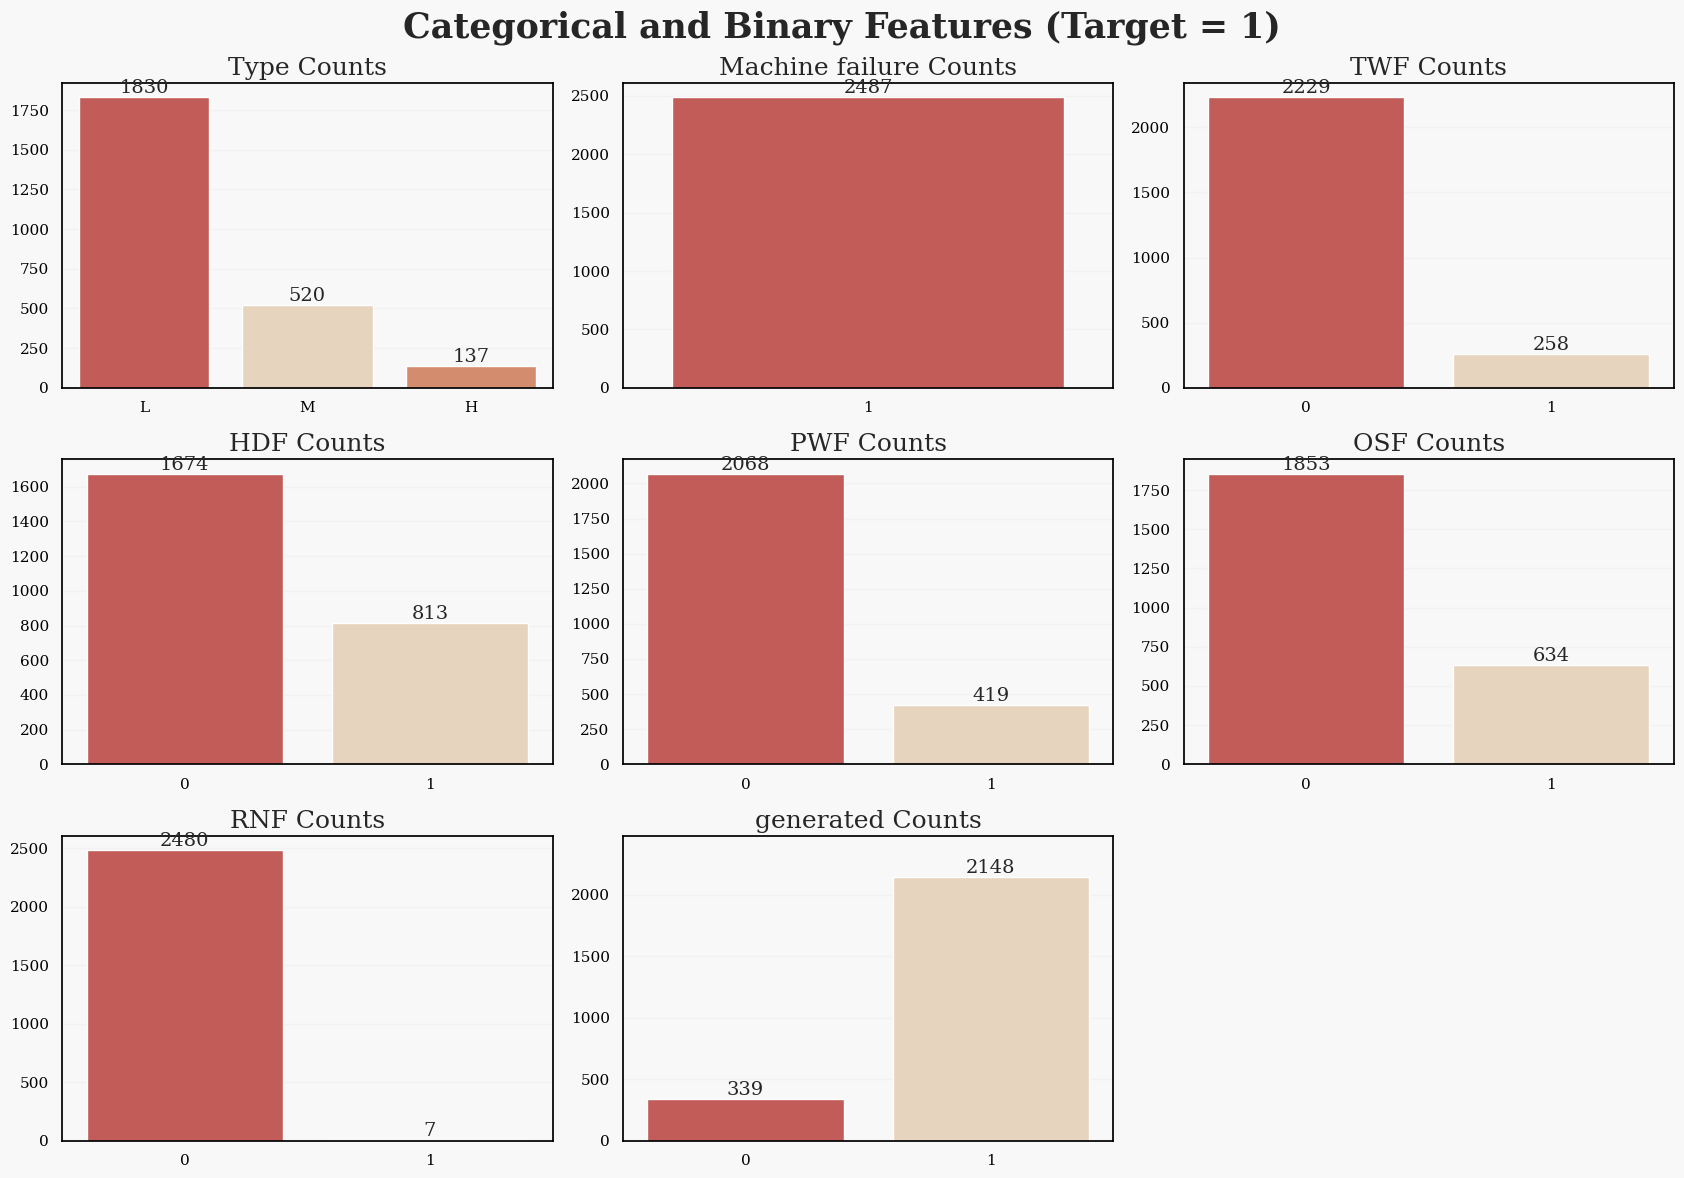

In [14]:
plot_count(train[train['Machine failure']==1],columns,3, plotname = 'Categorical and Binary Features (Target = 1)')

In [15]:
corr = train.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,generated
Air temperature [K],1.000000,0.857645,0.017702,-0.007564,0.017026,0.069595,0.004853,0.104220,0.007832,0.007573,0.005641,-0.019152
Process temperature [K],0.857645,1.000000,0.012359,-0.007073,0.012988,0.031734,0.004956,0.043093,0.003222,0.005473,0.005573,-0.011685
Rotational speed [rpm],0.017702,0.012359,1.000000,-0.788496,0.004104,-0.057575,-0.002884,-0.085981,0.065107,-0.066037,-0.004226,-0.032777
Torque [Nm],-0.007564,-0.007073,-0.788496,1.000000,-0.003289,0.150027,0.009153,0.104958,0.053833,0.116844,0.008584,0.010597
Tool wear [min],0.017026,0.012988,0.004104,-0.003289,1.000000,0.061215,0.053629,0.010658,0.005800,0.072668,-0.001257,-0.013972
Machine failure,0.069595,0.031734,-0.057575,0.150027,0.061215,1.000000,0.319621,0.566309,0.406044,0.500060,0.001619,-0.035443
TWF,0.004853,0.004956,-0.002884,0.009153,0.053629,0.319621,1.000000,0.007767,0.034194,0.036778,0.004912,-0.018321
HDF,0.104220,0.043093,-0.085981,0.104958,0.010658,0.566309,0.007767,1.000000,0.042090,0.064555,0.000332,-0.021443
PWF,0.007832,0.003222,0.065107,0.053833,0.005800,0.406044,0.034194,0.042090,1.000000,0.095089,0.000155,-0.033424
OSF,0.007573,0.005473,-0.066037,0.116844,0.072668,0.500060,0.036778,0.064555,0.095089,1.000000,-0.000933,-0.022373



#### ***The skewness of some variables is large and the proportion of positive and negative samples differs very much.***
#### ***Therefore, we will need to use some oversampling methods.***

# Data Engineering

___

### ***6 categorical variables in the dataset：`Type`,`TWF`,`HDF`,`PWF`,`OSF`,`RNF`,`generated`***
### ***We don't need to transfomer all of them because most of them are binary variable.***

In [16]:
Y = train['Machine failure']
X = train.drop('Machine failure', axis=1)

X.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,generated
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,1
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,1
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,1
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,1
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,1


In [17]:
var_cate = ['Type','TWF','HDF','PWF','OSF','RNF','generated']

#### ***Here i creat some new features, the original idea is from discussion.***

In [18]:
# onehot encoding and normalization
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

def data_engineering(df,var_cate):
    # rename columns
    for i in df.columns:
        df.columns = df.columns.str.replace('[\[\]]', '', regex=True)

    
    # label encoding for Type colum
    df['Type']=df['Type'].replace({"L":0,"M":1,"H":2})

    # new features
    df['Power'] = df['Torque Nm'] * df['Rotational speed rpm']
    df['Temp_ratio'] = df['Process temperature K'] / df['Air temperature K']
    df['Process temperature C'] = df['Process temperature K'] - 273.15
    df["Air temperature C"] = df["Air temperature K"] - 273.15
    df["temp_C_ratio"] = df["Process temperature C"] / df["Air temperature C"]
    df["Failure Sum"] = (df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"])
    df["tool_wear_speed"] = df["Tool wear min"] * df["Rotational speed rpm"]
    df["torque wear ratio"] = df["Torque Nm"] / (df["Tool wear min"] + 0.0001)
    df["torque times wear"] = df["Torque Nm"] * df["Tool wear min"]

    # normalization
    scaler = StandardScaler()
    for i in [i for i in df.columns if i not in ['Machine failure'] and i not in var_cate]:
        df[i] = scaler.fit_transform(df[[i]])
    
    return df
    

In [19]:
X = data_engineering(X,var_cate)
test = data_engineering(test,var_cate)

# Oversampling

#### ***Someone in the Discussion section suggested that Oversampling doesn't seem to do much, but I don't have much choice. In any case, more data should make the model more robust.***
___

In [20]:
from imblearn.over_sampling import SMOTE

print('Shape of train data before oversampling:',X.shape)
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)
print('Shape of train data after oversampling:',X_res.shape)

Shape of train data before oversampling: (146429, 21)
Shape of train data after oversampling: (287884, 21)


#### ***Now we are ready for modeling.***

# Features Selection

In [21]:
'''from tqdm import tqdm
# models

results_df = pd.DataFrame()

lgb_md = LGBMClassifier()
xgb_md = XGBClassifier()


models = [lgb_md,xgb_md]

def perform_feature_selection(model, X, y):
    rfecv = RFECV(model, 
            step=1,
            min_features_to_select=10,
            cv=2,
            scoring='roc_auc', 
            n_jobs=-1)
    with tqdm(total=X.shape[1], desc="Feature Selection", leave=False) as pbar:
        rfecv.fit(X, y)
        pbar.update(rfecv.support_.sum())
    selected_features = rfecv.support_
    feature_ranking = rfecv.ranking_
    return selected_features, feature_ranking


# use lgb model to select features
lgb_selected_features, lgb_feature_ranking = perform_feature_selection(lgb_md, X,Y)

# use xgb model to select features
xgb_selected_features, xgb_feature_ranking = perform_feature_selection(xgb_md, X,Y)'''


'from tqdm import tqdm\n# models\n\nresults_df = pd.DataFrame()\n\nlgb_md = LGBMClassifier()\nxgb_md = XGBClassifier()\n\n\nmodels = [lgb_md,xgb_md]\n\ndef perform_feature_selection(model, X, y):\n    rfecv = RFECV(model, \n            step=1,\n            min_features_to_select=10,\n            cv=2,\n            scoring=\'roc_auc\', \n            n_jobs=-1)\n    with tqdm(total=X.shape[1], desc="Feature Selection", leave=False) as pbar:\n        rfecv.fit(X, y)\n        pbar.update(rfecv.support_.sum())\n    selected_features = rfecv.support_\n    feature_ranking = rfecv.ranking_\n    return selected_features, feature_ranking\n\n\n# use lgb model to select features\nlgb_selected_features, lgb_feature_ranking = perform_feature_selection(lgb_md, X,Y)\n\n# use xgb model to select features\nxgb_selected_features, xgb_feature_ranking = perform_feature_selection(xgb_md, X,Y)'

In [22]:
'''rank_feature = pd.DataFrame({'Feature Name': X.columns, 'LGB': lgb_feature_ranking, 'XGB': xgb_feature_ranking})
rank_feature['mean'] = (rank_feature['LGB'] + rank_feature['XGB'])/2
rank_feature'''

"rank_feature = pd.DataFrame({'Feature Name': X.columns, 'LGB': lgb_feature_ranking, 'XGB': xgb_feature_ranking})\nrank_feature['mean'] = (rank_feature['LGB'] + rank_feature['XGB'])/2\nrank_feature"

### ***I will put the result here: 'Air temperature C','Process temperature C','OSF' are features i'm going to delete because they are not performing well in REFCV . You can run the code if want.***


In [23]:
columns_to_exclude = ['Air temperature C', 'Process temperature C', 'OSF']
X = X.drop(columns=columns_to_exclude)
test = test.drop(columns=columns_to_exclude)

# Modeling

### ***Here I selected some models and try to optimizar them.***

### ***And also an Ensemble model.***

## Search best params for classifers

### ***The process of finding hyperparameters is in Version 5.***

### LGBM

In [24]:
import optuna

'''def obj_lgb(trial):
    params = {
        'random_state': 23,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 10,50),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    
    lgb_md = LGBMClassifier(**params)  
    lgb_md.fit(X_skf_train, y_skf_train) 
    y_skf_pred = lgb_md.predict(X_skf_val)
    roc_auc = roc_auc_score(y_skf_val, y_skf_pred)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(obj_lgb, n_trials=100)
display(study)

print('Best trial:', study.best_trial.params)
print('Best ROC AUC:', study.best_trial.value)

lgb_optimized_params = study.best_trial.params

## Additional params
lgb_optimized_params['objective'] = 'binary'
lgb_optimized_params['metric'] = 'binary_logloss'

lgb_md = LGBMClassifier(**lgb_optimized_params)
lgb_md
'''

"def obj_lgb(trial):\n    params = {\n        'random_state': 23,\n        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1.0),\n        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0),\n        'num_leaves': trial.suggest_int('num_leaves', 2, 500),\n        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),\n        'max_depth': trial.suggest_int('max_depth', 10,50),\n        'subsample': trial.suggest_float('subsample', 0.1, 1.0),\n        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)\n    }\n    \n    lgb_md = LGBMClassifier(**params)  \n    lgb_md.fit(X_skf_train, y_skf_train) \n    y_skf_pred = lgb_md.predict(X_skf_val)\n    roc_auc = roc_auc_score(y_skf_val, y_skf_pred)\n\n    return roc_auc\n\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(obj_lgb, n_trials=100)\ndisplay(study)\n\nprint('Best trial:', study.best_trial.params)\nprint('Best ROC AUC:', study.best_trial.value)\n\nlgb_optimized_params = study.

In [25]:
lgb_md = LGBMClassifier(learning_rate=0.0124415817896377, max_depth=37,
               metric='binary_error', min_child_samples=102, num_leaves=249,
               objective='binary', reg_alpha=0.00139174509988134,
               reg_lambda=0.000178964551019674, subsample=0.421482143660471,
               boosting_type = 'gbdt',subsample_freq = 4)

### XGB

In [26]:
'''def obj_xgb(trial):
    params = {
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),    
    }
    
    xgb_md = XGBClassifier(reg_alpha = 0.18727857702097278,reg_lambda = 0.77217672456579,
                           learning_rate = 0.043011675696849064, max_depth = 15, subsample = 0.8370545840097189,
                             random_state = 23,min_child_weight = 60,**params)  
    xgb_md.fit(X_skf_train, y_skf_train) 
    y_skf_pred = xgb_md.predict(X_skf_val)
    roc_auc = roc_auc_score(y_skf_val, y_skf_pred)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(obj_xgb, n_trials=50)
display(study)

print('Best trial:', study.best_trial.params)
print('Best ROC AUC:', study.best_trial.value)

xgb_optimized_params = study.best_trial.params

## Additional params

xgb_md = XGBClassifie(**xgb_optimized_params)
xgb_md '''

'def obj_xgb(trial):\n    params = {\n        \'eta\': trial.suggest_discrete_uniform(\'eta\', 0.01, 0.1, 0.01),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),    \n    }\n    \n    xgb_md = XGBClassifier(reg_alpha = 0.18727857702097278,reg_lambda = 0.77217672456579,\n                           learning_rate = 0.043011675696849064, max_depth = 15, subsample = 0.8370545840097189,\n                             random_state = 23,min_child_weight = 60,**params)  \n    xgb_md.fit(X_skf_train, y_skf_train) \n    y_skf_pred = xgb_md.predict(X_skf_val)\n    roc_auc = roc_auc_score(y_skf_val, y_skf_pred)\n\n    return roc_auc\n\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(obj_xgb, n_trials=50)\ndisplay(study)\n\nprint(\'Best trial:\', study.best_trial.params)\nprint(\'Best ROC AUC:\', study.best_trial.value)\n\nxgb_optimized_params = study.best_trial.params\n\n## Additional params\n\nxgb_md = XGBClassifie(**xgb_optimized_params)\nxgb_md '

In [27]:
xgb_md =  XGBClassifier(reg_alpha = 0.18727857702097278,
                        alpha = 0.0000162103492458353,
                        learning_rate = 0.00349356650247156, max_depth = 15, 
                        subsample = 0.8370545840097189, objective = 'binary:logistic',
                        random_state = 23,min_child_weight = 2, n_jobs = -1,
                        eta = 0.05, colsample_bytree = 0.244618079894501,booster = 'gbtree')

In [28]:
gb_md = GradientBoostingClassifier(n_estimators = 500, 
                                   max_depth = 7, 
                                   learning_rate = 0.01,
                                   min_samples_split = 10, 
                                   min_samples_leaf = 20)

hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 1000,
                                             max_depth = 15,
                                             max_bins = 255,
                                             min_samples_leaf = 30,
                                             max_leaf_nodes = 30)

In [29]:
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ## GradientBoosting
    
    gb_md = GradientBoostingClassifier(n_estimators = 500, 
                                   max_depth = 7, 
                                   learning_rate = 0.01,
                                   min_samples_split = 10, 
                                   min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    gb_pred_2 = gb_md.predict_proba(test)[:, 1]
            
    gb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i+1, '==> GradientBoositng oof ROC-AUC score is ==>', gb_score_fold)

    ## HistGradientBoosting 
       
    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 1000,
                                             max_depth = 15,
                                             max_bins = 255,
                                             min_samples_leaf = 30,
                                             max_leaf_nodes = 30).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    hist_pred_2 = hist_md.predict_proba(test)[:, 1]

    hist_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i+1, '==> HistGradient oof ROC-AUC score is ==>', hist_score_fold)
    
        
    ## LightGBM
        
    lgb_md.fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]

    lgb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i+1, '==> LightGBM oof ROC-AUC score is ==>', lgb_score_fold)
        
    ## XGBoost 
        
    xgb_md.fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    xgb_pred_2 = xgb_md.predict_proba(test)[:, 1]

    xgb_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i+1, '==> XGBoost oof ROC-AUC score is ==>', xgb_score_fold)

    ## Ensemble 
    
    ens_pred_1 = gb_pred_1 + hist_pred_1 + lgb_pred_1 + xgb_pred_1
    ens_pred_2 = gb_pred_2 + hist_pred_2 + lgb_pred_2 + xgb_pred_2
    
    ens_score_fold = roc_auc_score(Y_test[X_test['generated'] == 1], ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i+1, '==> Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof ROC-AUC score is ==> 0.9573891282009406
Fold 1 ==> HistGradient oof ROC-AUC score is ==> 0.9646202083716119
Fold 1 ==> LightGBM oof ROC-AUC score is ==> 0.967852962592464
Fold 1 ==> XGBoost oof ROC-AUC score is ==> 0.957115223649021
Fold 1 ==> Ensemble oof ROC-AUC score is ==> 0.9675479247902332
---------------------------------------------------------------
Fold 2 ==> GradientBoositng oof ROC-AUC score is ==> 0.9523407820864096
Fold 2 ==> HistGradient oof ROC-AUC score is ==> 0.961437548715794
Fold 2 ==> LightGBM oof ROC-AUC score is ==> 0.9507229105802366
Fold 2 ==> XGBoost oof ROC-AUC score is ==> 0.9518097433994934
Fold 2 ==> Ensemble oof ROC-AUC score is ==> 0.95786416893391
---------------------------------------------------------------
Fold 3 ==> GradientBoositng oof ROC-AUC score is ==> 0.9596957271966241
Fold 3 ==> HistGradient oof ROC-AUC score is ==> 0.9617899304665745
Fold 3 ==> 

In [30]:
'''
# Simple Baselines models tests

from tqdm import tqdm

model_table = pd.DataFrame(columns = ['Model Name', 'Score'])
def model_accuracy(model,model_name,X,y):
    print('Starting Iteration for',model_name)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores =[]
    for nfold, (train_idx, valid_idx) in enumerate(tqdm(kf.split(X, y), total=5)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the validation set and calculate MAE
        y_pred = model.predict_proba(X_valid)[:,1]
        roc = roc_auc_score(y_valid, y_pred)
        
        print(f'Iteration : {nfold+1}  ROC AUC: {roc:.5f}')
        
        roc_auc_scores.append(roc)
    
    i=len(model_table)
    model_table.loc[i,'Model Name']=model_name
    model_table.loc[i,'Score']=np.mean(roc_auc_scores)


models = [
      ('CatBoost Classifier',CatBoostClassifier(verbose= False)),
      ('RandomForestClassifier', RandomForestClassifier(random_state=1)),
      ('KNeighborsClassifier', KNeighborsClassifier()),
      ('XGBClassifier', XGBClassifier(random_state=42))
]

for label,model in models:
    model_accuracy(model,label,X_res,Y_res)
    
    
display(model_table.sort_values(by='Score', ascending=False).style.background_gradient(cmap='summer_r'))

print("Baseline Validation done!")

selected_models = [
      ('cat', CatBoostClassifier(verbose= False)),
      ('lgb', LGBMClassifier()),
      ('xgb', XGBClassifier(random_state=42)),
      ('knn', KNeighborsClassifier()),
]

voting_clf = VotingClassifier(estimators = models, voting="soft")

model_accuracy(voting_clf,'Voting',X_res,Y_res)

display(model_table.sort_values(by='Score', ascending=False).style.background_gradient(cmap='summer_r'))


model=voting_clf
model.fit(X_res,Y_res)
preds = model.predict_proba(test)[:,1]

sample_submission['Machine failure'] = preds

sample_submission.to_csv('submission.csv',index=False)
    '''

'\n# Simple Baselines models tests\n\nfrom tqdm import tqdm\n\nmodel_table = pd.DataFrame(columns = [\'Model Name\', \'Score\'])\ndef model_accuracy(model,model_name,X,y):\n    print(\'Starting Iteration for\',model_name)\n    kf = KFold(n_splits=5, shuffle=True, random_state=42)\n    roc_auc_scores =[]\n    for nfold, (train_idx, valid_idx) in enumerate(tqdm(kf.split(X, y), total=5)):\n        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]\n        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]\n    \n        # Train the model\n        model.fit(X_train, y_train)\n\n        # Predict on the validation set and calculate MAE\n        y_pred = model.predict_proba(X_valid)[:,1]\n        roc = roc_auc_score(y_valid, y_pred)\n        \n        print(f\'Iteration : {nfold+1}  ROC AUC: {roc:.5f}\')\n        \n        roc_auc_scores.append(roc)\n    \n    i=len(model_table)\n    model_table.loc[i,\'Model Name\']=model_name\n    model_table.loc[i,\'Score\']=np.mean(roc_auc_sco

In [31]:
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

baseline_score = pd.DataFrame(index=['cv_score'])


baseline_score['LightGBM'] = lgb_cv_score
baseline_score['XGBoost'] = xgb_cv_score
baseline_score['Ensemble'] = ens_cv_score

In [32]:
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

submission['Machine failure'] = lgb_preds_test
submission.to_csv('LightGBM_Baseline_submission.csv', index = False)

submission['Machine failure'] = xgb_preds_test
submission.to_csv('XGBoost_Baseline_submission.csv', index = False)

submission['Machine failure'] = ens_preds_test
submission.to_csv('Ensemble_Baseline_submission.csv', index = False)

# Hope you find this notebook helpful!